# 计算机网络体系结构第二次作业

作业要求：

> 1. 推导杜邦分析公式：ROE = 净利润率 x 总资产周转率 x 权益乘数，并简要分析宏观经济放缓对于 ROE 的影响。
> 2. 因为假的东西难以长久，看财报最好多看几年。1）利用 akshare 库获取上市公司的财务报表数据（代码参考附录 1），计算每只股票在 2021 年至 2023 年期间的 ROE（由于 akshare 没有给出归母净利润，这里假设净利润 = 归母净利润）。2）希望对同一板块的公司进行 ROE 的横向比较。
> 3. 在 2 的基础上，针对于 ROE 最高的公司，根据其某一年，如 2023 年的年度报表，进行杜邦分析。（markdown 画图可参考附录 2）

## 理论推导

### 杜邦分析公式

杜邦分析公式是一个用于分解公司 ROE 的公式，它将 ROE 分解为三个部分：净利润率、总资产周转率和权益乘数。具体推导如下：

$$
\begin{alignat*}{3}
    \text{净利润率}    & \coloneqq \frac{\text{归母净利润}}{\text{营业收入}} \tag{净利润率} \\
    \text{总资产周转率} & \coloneqq \frac{\text{营业收入}}{\text{平均总资产}} \tag{总资产周转率} \\
    \text{权益乘数}    & \coloneqq \frac{1}{1 - 资产负债率} \tag{权益乘数} \\
                      & = \frac{1}{1 - \frac{平均总负债}{平均总资产}} \\
                      & = \frac{平均总资产}{平均总资产 - 平均总负债} \\
                      & = \frac{\text{平均总资产}}{\text{净资产}} \\
    ROE               & \coloneqq \frac{\text{归母净利润}}{\text{净资产}} \tag{净资产收益率} \\
                      & = \frac{\text{归母净利润}}{\text{营业收入}} \times \frac{\text{营业收入}}{\text{净资产}} \\
                      & = \frac{\text{归母净利润}}{\text{营业收入}} \times \frac{\text{营业收入}}{\text{平均总资产}} \times \frac{\text{平均总资产}}{\text{净资产}} \\
                      & = \text{净利润率} \times \text{总资产周转率} \times \text{权益乘数}
\end{alignat*}
$$

## 实验设置


## 实验原理、实现、结果与分析


### 数据准备


In [368]:
from typing import Callable
from pylab import mpl
from matplotlib import pyplot as plt
import akshare as ak
import os
import os.path as path
import pandas as pd
import pathlib as pl


# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["Songti SC"]
mpl.rcParams["axes.unicode_minus"] = False


class DataLoader:
    """
    Load data from akshare and save it to local file.
    """
    stock_zcfz_em_df: pd.DataFrame
    stock_lrb_em_df: pd.DataFrame
    stock_xjll_em_df: pd.DataFrame

    def __init__(self, date: str):
        self.load_data(date)

    @staticmethod
    def load_df(p: pl.Path, getter: Callable[[], pd.DataFrame]):
        '''
        Load DataFrame from local file, if the file does not exist, call getter to get the data.
        '''
        if not path.exists(p):
            df = getter()
            df.set_index("股票代码", inplace=True)
            df.to_pickle(p)
        # 如果我们不使用pd.read_json，而是直接使用pd.read_csv，会导致数据类型不一致
        # 例如，有的列是int，有的列是float
        return pd.read_pickle(p)

    def load_data(self, date: str):
        DIR = pl.Path("data")
        os.makedirs(DIR, exist_ok=True)
        self.stock_zcfz_em_df = self.load_df(
            DIR / f"stock_zcfz_em-{date}.pkl",
            lambda: ak.stock_zcfz_em(date=date)
        )
        self.stock_lrb_em_df = self.load_df(
            DIR / f"stock_lrb_em-{date}.pkl",
            lambda: ak.stock_lrb_em(date=date)
        )
        self.stock_xjll_em_df = self.load_df(
            DIR / f"stock_xjll_em-{date}.pkl",
            lambda: ak.stock_xjll_em(date=date)
        )

- 读取财务数据，并查看可用的信息。


In [369]:
DATES = ["20201231", "20211231", "20221231", "20231231"]
data = {date: DataLoader(date) for date in DATES}

start = data["20201231"]
following = [data[d] for d in DATES[1:]]
end = data["20231231"]
print(start.stock_zcfz_em_df.columns)
print(start.stock_lrb_em_df.columns)
print(start.stock_xjll_em_df.columns)

Index(['序号', '股票简称', '资产-货币资金', '资产-应收账款', '资产-存货', '资产-总资产', '资产-总资产同比',
       '负债-应付账款', '负债-预收账款', '负债-总负债', '负债-总负债同比', '资产负债率', '股东权益合计', '公告日期'],
      dtype='object')
Index(['序号', '股票简称', '净利润', '净利润同比', '营业总收入', '营业总收入同比', '营业总支出-营业支出',
       '营业总支出-销售费用', '营业总支出-管理费用', '营业总支出-财务费用', '营业总支出-营业总支出', '营业利润', '利润总额',
       '公告日期'],
      dtype='object')
Index(['序号', '股票简称', '净现金流-净现金流', '净现金流-同比增长', '经营性现金流-现金流量净额',
       '经营性现金流-净现金流占比', '投资性现金流-现金流量净额', '投资性现金流-净现金流占比', '融资性现金流-现金流量净额',
       '融资性现金流-净现金流占比', '公告日期'],
      dtype='object')


- 查看资产负债率概况。


In [370]:
print(pd.DataFrame.from_dict({
    date: data[date].stock_zcfz_em_df.资产负债率.describe() for date in DATES
}))

           20201231     20211231     20221231     20231231
count   5170.000000  5166.000000  5131.000000  2425.000000
mean      45.782102    42.627869    42.255226    40.941066
std      248.432711    21.657775    22.613517    21.266721
min        1.306203     1.495593     1.557874     2.107879
25%       25.746219    25.782649    24.701444    23.739977
50%       40.902024    41.091894    40.611636    39.638593
75%       56.628315    56.864707    57.016438    55.932779
max    17834.547318   159.237049   244.153123   122.284584


- 查看年度净利润概况。


In [371]:
print(pd.DataFrame.from_dict({
    date: data[date].stock_lrb_em_df['净利润'].describe() for date in DATES
}))

           20201231      20211231      20221231      20231231
count  5.170000e+03  5.166000e+03  5.158000e+03  2.425000e+03
mean   8.395560e+08  1.000283e+09  1.026978e+09  1.813387e+09
std    8.313098e+09  9.345872e+09  1.024536e+10  1.459529e+10
min   -6.400331e+10 -4.326461e+10 -3.861950e+10 -8.168000e+09
25%    4.776486e+07  4.684590e+07  2.198180e+07  4.762086e+07
50%    1.116375e+08  1.242840e+08  1.116990e+08  1.595813e+08
75%    3.285773e+08  3.887146e+08  3.682492e+08  5.261305e+08
max    3.159060e+11  3.483380e+11  3.611320e+11  3.639930e+11


- 收集在 2021 年到 2023 年都处于上市状态的股票。


In [372]:
codes = set(start.stock_zcfz_em_df.index.array)
for date in DATES[1:]:
    codes = codes.intersection(set(data[date].stock_zcfz_em_df.index.array))
list_codes = [*codes]
list_codes.sort()
print(len(list_codes))

2425


### 计算各项指标

- 计算三年内的净利润之和与营业总收入。


In [373]:
profits = pd.DataFrame.from_dict({
    date: data[date].stock_lrb_em_df.loc[list_codes, "净利润"]
    for date in DATES
}).sum(axis=1)
gains = pd.DataFrame.from_dict({
    date: data[date].stock_lrb_em_df.loc[list_codes, "营业总收入"]
    for date in DATES
}).sum(axis=1)
print(profits.describe())
print(gains.describe())

count    2.425000e+03
mean     6.795349e+09
std      5.388636e+10
min     -7.071762e+10
25%      2.241070e+08
50%      6.292772e+08
75%      2.035861e+09
max      1.389369e+12
dtype: float64
count    2.425000e+03
mean     7.774528e+10
std      4.549609e+11
min      1.650822e+06
25%      3.485206e+09
50%      8.807435e+09
75%      2.813832e+10
max      1.137599e+13
dtype: float64


- 计算如下指标：净利润率、总资产周转率、权益乘数和 ROE。

In [374]:
result = pd.DataFrame({
    '股票代码': list_codes,
    '股票简称': start.stock_zcfz_em_df.loc[list_codes, '股票简称'],
    '归母净利润':  profits,
    '营业收入': gains,
    '平均总资产': (start.stock_zcfz_em_df.loc[list_codes, '资产-总资产'] +
              end.stock_zcfz_em_df.loc[list_codes, '资产-总资产']) / 2,
    '平均总负债': (start.stock_zcfz_em_df.loc[list_codes, '负债-总负债'] +
              end.stock_zcfz_em_df.loc[list_codes, '负债-总负债']) / 2,
})
result.set_index('股票代码', inplace=True)
result['营业净利润率'] = result['归母净利润'] / result['营业收入']
result['总资产周转率'] = result['营业收入'] / result['平均总资产']
result['资产负债率'] = result['平均总负债'] / result['平均总资产']
result['净资产'] = result['平均总资产'] - result['平均总负债']
result['权益乘数'] = result['平均总资产'] / result['净资产']
result['净资产收益率'] = result['归母净利润'] / result['净资产']

- 去除净资产为负的股票。

In [375]:
print(result[result.loc[:, '净资产'] <= 0])
result = result[result.loc[:, '净资产'] > 0]

        股票简称         归母净利润          营业收入         平均总资产         平均总负债  \
股票代码                                                                   
000523  红棉股份 -3.234084e+09  1.116685e+10  3.307607e+09  4.154008e+09   
002356  赫美集团  2.869680e+08  1.126689e+09  9.658484e+08  2.167062e+09   
002766  索菱股份 -1.934133e+09  3.876476e+09  1.713844e+09  1.742275e+09   
600518  ST康美 -2.575257e+10  1.861870e+10  2.380325e+10  2.546784e+10   
600734  ST实达  3.840681e+07  2.671087e+09  1.477955e+09  1.863208e+09   
688520  神州细胞 -2.494369e+09  3.045247e+09  2.191024e+09  2.199749e+09   

          营业净利润率    总资产周转率     资产负债率           净资产        权益乘数      净资产收益率  
股票代码                                                                        
000523 -0.289615  3.376113  1.255895 -8.464008e+08   -3.907850    3.820984  
002356  0.254700  1.166527  2.243687 -1.201213e+09   -0.804061   -0.238899  
002766 -0.498941  2.261861  1.016589 -2.843144e+07  -60.279875   68.027971  
600518 -1.383156  0.782191  1.069931 -

- 去除归母净利润为负的股票。

In [376]:
print(result[result.loc[:, '归母净利润'] <= 0])
result = result[result.loc[:, '归母净利润'] > 0]

        股票简称         归母净利润          营业收入         平均总资产         平均总负债  \
股票代码                                                                   
000008  神州高铁 -3.963355e+09  8.416924e+09  1.174188e+10  6.580397e+09   
000016  深康佳A -2.251271e+09  1.469155e+11  4.285054e+10  3.453678e+10   
000037  深南电A -5.314289e+08  3.026437e+09  2.535098e+09  7.958202e+08   
000050  深天马A -5.457656e+08  1.267171e+11  7.776706e+10  4.648602e+10   
000069  华侨城A -9.119733e+08  3.169975e+11  4.157349e+11  3.176404e+11   
...      ...           ...           ...           ...           ...   
688469  芯联集成 -5.648468e+09  1.269391e+10  1.998801e+10  9.730185e+09   
688488  艾迪药业 -1.903767e+08  1.200349e+09  1.596696e+09  3.539986e+08   
688521  芯原股份 -2.349265e+08  8.662431e+09  3.800806e+09  1.137435e+09   
688538  和辉光电 -6.827457e+09  1.375193e+10  2.660565e+10  1.515458e+10   
688660  电气风电 -6.856357e+08  6.637272e+10  2.881188e+10  2.371239e+10   

          营业净利润率    总资产周转率     资产负债率           净资产      权益乘数   

- 查看计算结果的概况。

In [377]:
result.describe()

,归母净利润,营业收入,平均总资产,平均总负债,营业净利润率,总资产周转率,资产负债率,净资产,权益乘数,净资产收益率
count,2.101000e+03,2.101000e+03,2.101000e+03,2.101000e+03,2101.000000,2101.000000,2101.000000,2.101000e+03,2101.000000,2101.000000
mean,8.133626e+09,8.537976e+10,1.449550e+11,1.230598e+11,0.125672,2.428654,0.396476,2.189523e+10,2.026713,0.366162
std,5.770163e+10,4.872186e+11,1.607937e+12,1.472757e+12,0.135044,1.736429,0.198244,1.448030e+11,1.539674,0.262962
min,2.014258e+06,9.143458e+07,2.345061e+08,2.224570e+07,0.000934,0.079282,0.027310,1.744578e+07,1.028077,0.000850
25%,3.608429e+08,3.779051e+09,1.960773e+09,5.291125e+08,0.048635,1.459573,0.235293,1.273889e+09,1.307690,0.203578
50%,8.221003e+08,9.572210e+09,4.488250e+09,1.557358e+09,0.099844,2.102810,0.377423,2.677206e+09,1.606227,0.333880
75%,2.435178e+09,3.045518e+10,1.333414e+10,6.202251e+09,0.165864,2.954416,0.534931,7.225705e+09,2.150217,0.477703
max,1.389369e+12,1.137599e+13,3.902107e+13,3.567802e+13,2.786849,19.711469,0.939825,3.343052e+12,16.618060,6.874037


- 查看营业净利润率的概况。

<Axes: xlabel='股票代码'>

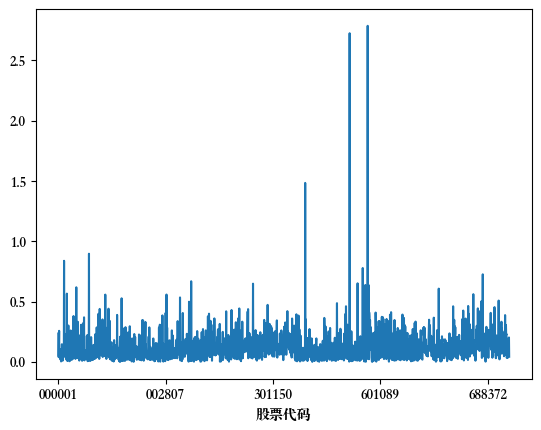

In [378]:
result.loc[:, '营业净利润率'].plot()

- 查看总资产周转率的概况。

<Axes: xlabel='股票代码'>

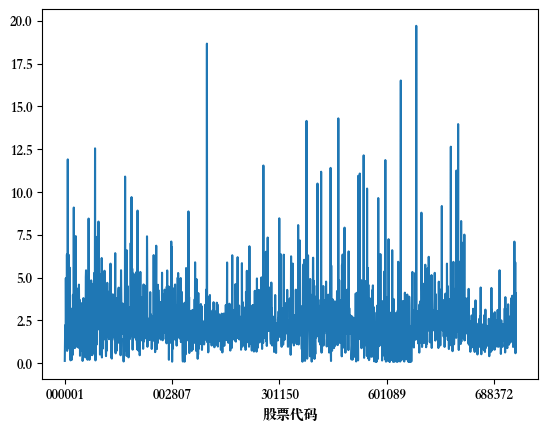

In [379]:
result.loc[:, '总资产周转率'].plot()

- 查看权益乘数的概况。

<Axes: xlabel='股票代码'>

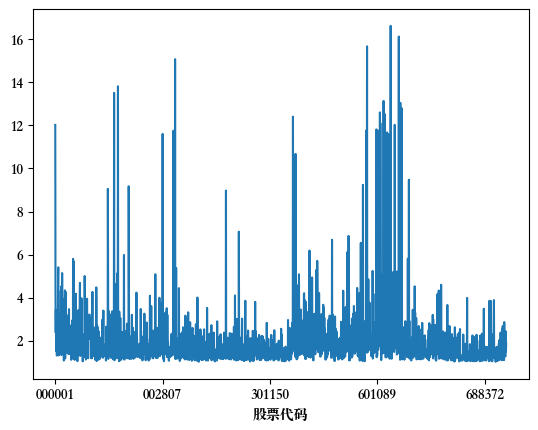

In [380]:
result.loc[:, '权益乘数'].plot()

- 查看 ROE 的概况。

<Axes: xlabel='股票代码'>

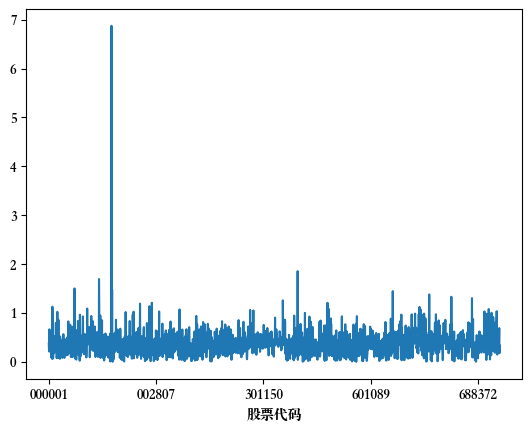

In [381]:
result.loc[:, '净资产收益率'].plot()

### 板块分析

#### 概念板块分析

In [382]:
def cache(p: pl.Path, getter: Callable[[], pd.DataFrame]) -> pd.DataFrame:
    if not path.exists(p):
        df = getter()
        df.to_pickle(p)
    return pd.read_pickle(p)

In [383]:
DIR = pl.Path('data/concept_board')
os.makedirs(DIR, exist_ok=True)
concept_board = cache(
    pl.Path("data/concept_board.pkl"), lambda: ak.stock_board_concept_name_em())
concept_boards = {
    name: cache(pl.Path(DIR / f"{name.replace('/', ',')}.pkl"), lambda: ak.stock_board_concept_cons_em(name)) for name in concept_board['板块名称']
}

In [384]:
for name, board in concept_boards.items():
    concept_boards_available = set(
        board.loc[:, '代码']).intersection(codes)
    print(name, concept_boards_available)

鸡肉概念 {'603609', '000895', '300967', '300761', '002299', '002234', '002458', '002982', '002321', '603477'}
猪肉概念 {'000002', '603609', '002726', '000702', '300761', '002661', '000048', '600975', '002458', '002982', '000895', '603477', '600073'}
空间站概念 {'002046', '300324', '000561', '001208', '688139', '600879', '688586', '300354', '300455', '600118', '300213', '000901'}
免疫治疗 {'600568', '002592', '300016', '300558', '688266', '300485', '002019', '688062', '300181', '600851', '300009', '600196', '688278', '002030', '002191', '300238'}
MLCC {'002859', '603267', '002669', '300285', '603678', '300726', '000636'}
白酒 {'600059', '600750', '600519', '600702', '600153', '600332', '601579', '002646', '002186', '002183', '600655', '002374', '603919', '000501', '600257', '600252', '002419', '600189'}
宠物经济 {'603609', '301376', '603182', '301283', '300703', '301108', '600655', '605507', '605009', '300783', '300841', '301156', '301498', '600195', '300119'}
军民融合 {'003009', '688776', '300922', '600990', '60

In [385]:
DIR = pl.Path('data/industry_board')
os.makedirs(DIR, exist_ok=True)
industry_board = cache(
    pl.Path("data/industry_board.pkl"), lambda: ak.stock_board_industry_name_em())
industry_boards = {
    name: cache(pl.Path(DIR / f"{name}.pkl"), lambda: ak.stock_board_industry_cons_em(name)) for name in industry_board['板块名称']
}

In [386]:
for name, board in industry_boards.items():
    industry_boards_available = set(
        board.loc[:, '代码']).intersection(codes)
    print(name, industry_boards_available)

旅游酒店 {'002033', '000721', '002186', '600576', '600054', '000428', '000978', '601888', '002627', '000069', '600258', '002059', '000524', '600749', '600138', '000888', '603099', '600754', '603199', '601007'}
酿酒行业 {'600059', '000929', '600600', '600519', '600702', '600573', '600132', '601579', '002646', '000869', '002461', '603919', '600616', '600543', '001338', '000729'}
航天航空 {'688563', '600391', '003009', '688543', '002933', '600893', '300775', '688066', '000697', '600038', '600372', '600879', '300719', '688510', '000768', '600760', '000738', '002297', '688586', '688297', '600862', '300722', '300581', '600316', '600765', '300114', '600118'}
美容护理 {'600315', '002094', '300896', '600249', '603605', '605009', '300955', '300856', '002243', '003006'}
生物制品 {'002007', '688276', '688180', '688687', '301207', '688176', '000661', '688302', '688177', '688488', '301301', '300294', '300204', '301509', '688278', '301393', '300357', '300142', '688331', '300485', '688336', '000534', '600867', '600161', 

## 实验总结与自评分


## 感谢和收获
